# **CNN Encoder Decoder SE Block with face images**

In the present computational notebook, we have executed the implementation of a convolutional autoencoder that incorporates a Squeeze-and-Excitation (SE) block nestled between the encoder and decoder modules. This strategic integration of the SE block is aimed at 

amplifying the model's performance through discerning and accentuating the most pertinent filters for the task of color reconstruction.

This design adaptation originates from a deliberate focus on the coloring reconstruction task, which is primarily rooted in our dataset that comprises of various facial images. The dataset has been meticulously utilized for both the training and testing processes, offering a comprehensive and relevant knowledge base for the model to learn from.

For more in-depth understanding and technical insights about Squeeze-and-Excitation Networks, readers are referred to the scholarly work by Hu et al., titled "Squeeze-and-Excitation Networks", presented at the Computer Vision and Pattern Recognition (CVPR) conference in 2018.

# Import necessary libraries

In [1]:
import random
import matplotlib.pyplot as plt
import zipfile
import io
from google.colab import files
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import numpy as np
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import cv2
from skimage import color
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset

# Connect to GPU if availble 

*Clear the CUDA memory cache. This releases all unoccupied cached memory so that those can be used by CUDA operations if necessary. This can help prevent the CUDA out-of-memory errors that can occur when the memory is filled up with cached, but unused data.*

In [2]:
torch.cuda.empty_cache()

In [3]:
# If this cell fails you need to change the runtime of your colab notebook to GPU
# Go to Runtime -> Change Runtime Type and select GPU
assert torch.cuda.is_available(), "GPU is not enabled"

#  Use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "tpu")

# Utils

*Upload zip file with face images and create different folders to split the data into train and validation.*

In [4]:
uploaded = files.upload()

Saving DeepColorization-master.zip to DeepColorization-master.zip


In [5]:
# Specify the file name of the uploaded ZIP file
zip_filename = "DeepColorization-master.zip"

# Extract the contents of the ZIP file
with zipfile.ZipFile(io.BytesIO(uploaded[zip_filename]), "r") as zip_ref:
    zip_ref.extractall("face_images")

In [6]:
# Path to the extracted dataset folder
dataset_folder_path = "/content/face_images/DeepColorization-master/face_images"

# Get the list of image files in the dataset folder
image_files = [f for f in os.listdir(dataset_folder_path) if os.path.isfile(os.path.join(dataset_folder_path, f))]

In [7]:
# Create directories for training and validation sets
train_folder = "/content/dataset/train"
val_folder = "/content/dataset/val"

# Create the directories if they don't exist
os.makedirs(train_folder, exist_ok=True)
os.makedirs(val_folder, exist_ok=True)

In [8]:
# Shuffle the image files list
random.shuffle(image_files)

# Determine the split ratio (e.g., 80% for training, 20% for validation)
split_ratio = 0.8
split_index = int(len(image_files) * split_ratio)

# Split the image files list into training and validation sets
train_image_files = image_files[:split_index]
val_image_files = image_files[split_index:]

In [9]:
# Iterate through the training set image files
for i, image_name in enumerate(train_image_files):
    image_path = os.path.join(dataset_folder_path, image_name)
    image = Image.open(image_path)

    colored_image_path = os.path.join(train_folder, image_name)
    image.save(colored_image_path)

In [10]:
# Iterate through the validation set image files
for image_name in val_image_files:
    image_path = os.path.join(dataset_folder_path, image_name)
    image = Image.open(image_path)

    # Save the colored image in the validation folder
    colored_image_path = os.path.join(val_folder, image_name)
    image.save(colored_image_path)

# LAB Colourspace

*Create a class in order to apply the necessary transformations to the images.*

In [11]:
# Define the ColorizationDataset class
class ColorizationDataset(Dataset):
    
    # Initialization method for the dataset
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir  # Root directory for the images
        self.transform = transform  # Transformations to be applied on images

        # List comprehension to get all file names in the root directory
        self.image_files = [f for f in os.listdir(root_dir) if os.path.isfile(os.path.join(root_dir, f))]
        
    # Method to get the length of the dataset
    def __len__(self):
        # Returns the length of the image files list
        return len(self.image_files)
        
    # Method to get an item from the dataset at a particular index
    def __getitem__(self, idx):
        # Get the image name at the particular index
        image_name = self.image_files[idx]

        # Form the complete image path
        image_path = os.path.join(self.root_dir, image_name)

        # Read the image
        image = cv2.imread(image_path)
        
        # Convert the image from BGR to LAB color space
        image_lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        
        # Split the LAB image into L, A, B channels. Here we only take the L channel.
        image_l = image_lab[:, :, 0]
        
        # Apply the transformation to the L channel (grayscale image)
        image_l = self.transform(image_l)

        # Apply the transformation to the complete LAB image
        image_lab = self.transform(image_lab)
        
        # Return the grayscale image (L channel) and the complete LAB image
        return image_l, image_lab


In [12]:
# Define the transformation to be applied to the images
transform = transforms.Compose([
    transforms.ToTensor()
])
# Define the path to your dataset directory
dataset_root = "/content/dataset/"

# Create an instance of the custom dataset
train_dataset = ColorizationDataset(os.path.join(dataset_root, "train"), transform=transform)

# Instance of the custom validation dataset
test_dataset = ColorizationDataset(os.path.join(dataset_root, "val"), transform=transform)

# Define the batch size for the DataLoader
batch_size = 128

# Create the DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create the DataLoader for validation
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model

*Define the architecture of the model.*

In [13]:
# Define the Convolutional AutoEncoder (ConvAE) class
class ConvAE(nn.Module):

    def __init__(self):
        super(ConvAE, self).__init__()
        
        # Define all layers used in the model

        # Convolutional layers for the encoder
        self.conv1 = nn.Conv2d(1, 16, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, stride=2, padding=1)

        # Pooling layer
        self.pooling = nn.AdaptiveAvgPool2d((1,1))

        # Fully connected layers for Squeeze and Excitation block
        self.fc1 = nn.Linear(64, 16)
        self.fc2 = nn.Linear(16, 64)

        # Deconvolutional layers for the decoder
        self.deconv1 = nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1)

    def encoder(self, x):
        # Encoding path of the model
        x = torch.nn.functional.relu(self.conv1(x))
        x = torch.nn.functional.relu(self.conv2(x))
        x = torch.nn.functional.relu(self.conv3(x))
        return x

    def SE_Block(self, x):
        # Squeeze and Excitation block
        batch_size, channels, height, width = x.size()

        # Squeeze operation: global average pooling
        squeeze = self.pooling(x).view(batch_size, channels)

        # Excitation operation: two-layer fully connected network
        excitation = torch.nn.functional.relu(self.fc1(squeeze))
        excitation = torch.sigmoid(self.fc2(excitation))

        # Re-calibration: scale the original feature map
        excitation = excitation.view(batch_size, channels, 1, 1)
        scaled_feature = x * excitation.expand_as(x)
        
        return scaled_feature

    def decoder(self, x):
        # Decoding path of the model
        x = torch.nn.functional.relu(self.deconv1(x))
        x = torch.nn.functional.relu(self.deconv2(x))
        x = torch.nn.functional.sigmoid(self.deconv3(x))
        return x

    def forward(self, x):
        # Forward path of the model
        encoded = self.encoder(x)
        att = self.SE_Block(encoded)
        decoded = self.decoder(att)
        return decoded

In [14]:
# Define a function to display an image
def show_image(img):

    # Clamp the input image pixel values to be in the range 0-1
    # img = img.clamp(0, 1)
    
    # Convert the PyTorch tensor to a NumPy array
    npimg = img.numpy()
    
    # Transpose the NumPy array so that the channel dimension is last (PyTorch uses C, H, W format and matplotlib uses H, W, C)
    npimg = np.transpose(npimg, (1, 2, 0))
    
    # Use matplotlib to display the image
    plt.imshow(npimg)
    
    # Show the image
    plt.show()

*Create an instance of the model and define the optimizer and criterion to use.*

In [15]:
# Instance of the model
model = ConvAE().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# L1 loss
criterion = nn.L1Loss()

# Training and Validation

*Define the training and test steps.*

In [18]:
# Function to perform training
def train(model, loader, optimizer, criterion, reshape=False):
    # Initialize loss as 0
    loss = 0

    # Set model in training mode
    model.train()

    # Iterate over batches
    for batch_features, feat in loader:
        # Move the batch tensors to the device we're using
        batch_features = batch_features.to(device)
        feat = feat.to(device)

        # Reshape the mini-batch data to a 2D matrix if the reshape flag is set
        if reshape:
            batch_features = batch_features.view(-1, 784)
        
        # Clear the gradients as PyTorch accumulates them on subsequent backward passes
        optimizer.zero_grad()
        
        # Perform the forward pass through the model (compute reconstructions)
        outputs = model(batch_features)
        
        # Compute the training reconstruction loss
        train_loss = criterion(outputs, feat)
        
        # Backpropagate the loss to compute gradients
        train_loss.backward()
        
        # Update the model parameters
        optimizer.step()
        
        # Add the mini-batch training loss to the epoch loss
        loss += train_loss.item()

    # Compute the epoch training loss (average loss over the entire dataset)
    loss = loss / len(loader)

    # Print the epoch training loss
    print("epoch : {}/{}, Train loss = {:.6f}".format(epoch + 1, epochs, loss))

    # Return the loss for this epoch
    return loss


# Function to perform testing
def test(model, loader, criterion, reshape=False):
    # Initialize loss as 0
    loss = 0

    # Set model in evaluation mode
    model.eval()
    
    # Iterate over batches
    for batch_features, feat in loader:
        # Move the batch tensors to the device we're using
        batch_features = batch_features.to(device)
        feat = feat.to(device)
        
        # Reshape the mini-batch data to a 2D matrix if the reshape flag is set
        if reshape:
            batch_features = batch_features.view(-1, 784)

        # Perform the forward pass through the model and prevent gradient computation to save memory
        with torch.no_grad():
            outputs = model(batch_features)
        
        # Compute the testing reconstruction loss
        test_loss = criterion(outputs, feat)
 
        # Add the mini-batch testing loss to the epoch loss
        loss += test_loss.item()
    
    # Compute the epoch testing loss (average loss over the entire dataset)
    loss = loss / len(loader)
    
    # Display the epoch testing loss
    print("epoch : {}/{}, Test loss = {:.6f}".format(epoch + 1, epochs, loss))

    # Display the original images and the reconstructed images from the model
    #show_image(make_grid(batch_features.detach().cpu(), nrow=4, normalize=True, pad_value=1))
    #show_image(make_grid(outputs.detach().cpu(), nrow=4, normalize=True, pad_value=1))

    # Return the loss for this epoch
    return loss

*Run the training and test.*

epoch : 1/200, Train loss = 0.090836
epoch : 1/200, Test loss = 0.090410
epoch : 2/200, Train loss = 0.090003
epoch : 2/200, Test loss = 0.089470
epoch : 3/200, Train loss = 0.089109
epoch : 3/200, Test loss = 0.088551
epoch : 4/200, Train loss = 0.088270
epoch : 4/200, Test loss = 0.087659
epoch : 5/200, Train loss = 0.087318
epoch : 5/200, Test loss = 0.086709
epoch : 6/200, Train loss = 0.086387
epoch : 6/200, Test loss = 0.085683
epoch : 7/200, Train loss = 0.085337
epoch : 7/200, Test loss = 0.084584
epoch : 8/200, Train loss = 0.084425
epoch : 8/200, Test loss = 0.083492
epoch : 9/200, Train loss = 0.083330
epoch : 9/200, Test loss = 0.082500
epoch : 10/200, Train loss = 0.082438
epoch : 10/200, Test loss = 0.081569
epoch : 11/200, Train loss = 0.081594
epoch : 11/200, Test loss = 0.080722
epoch : 12/200, Train loss = 0.080792
epoch : 12/200, Test loss = 0.079882
epoch : 13/200, Train loss = 0.079980
epoch : 13/200, Test loss = 0.079108
epoch : 14/200, Train loss = 0.079275
epoch

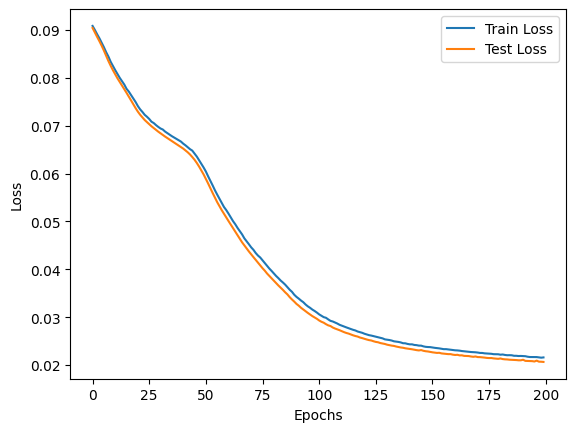

In [19]:
# Determine if CUDA is available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set the number of epochs for training
epochs = 200

# Initialize lists to store loss values for each epoch
train_loss_list = []
test_loss_list = []

# Training loop 
for epoch in range(epochs):
    # Train the model on the training data and get the training loss
    train_loss = train(model, train_loader, optimizer, criterion, reshape=False)
    
    # Test the model on the testing data and get the testing loss
    test_loss = test(model, test_loader, criterion, reshape=False)

    # Append the training and testing loss for this epoch to their respective lists
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)

# Plotting the loss curve

# Plot the training loss over epochs
plt.plot(train_loss_list, label='Train Loss')

# Plot the testing loss over epochs
plt.plot(test_loss_list, label='Test Loss')

# Label the x-axis as 'Epochs'
plt.xlabel('Epochs')

# Label the y-axis as 'Loss'
plt.ylabel('Loss')

# Display the legend
plt.legend()

# Show the plot
plt.show()

# Results with test

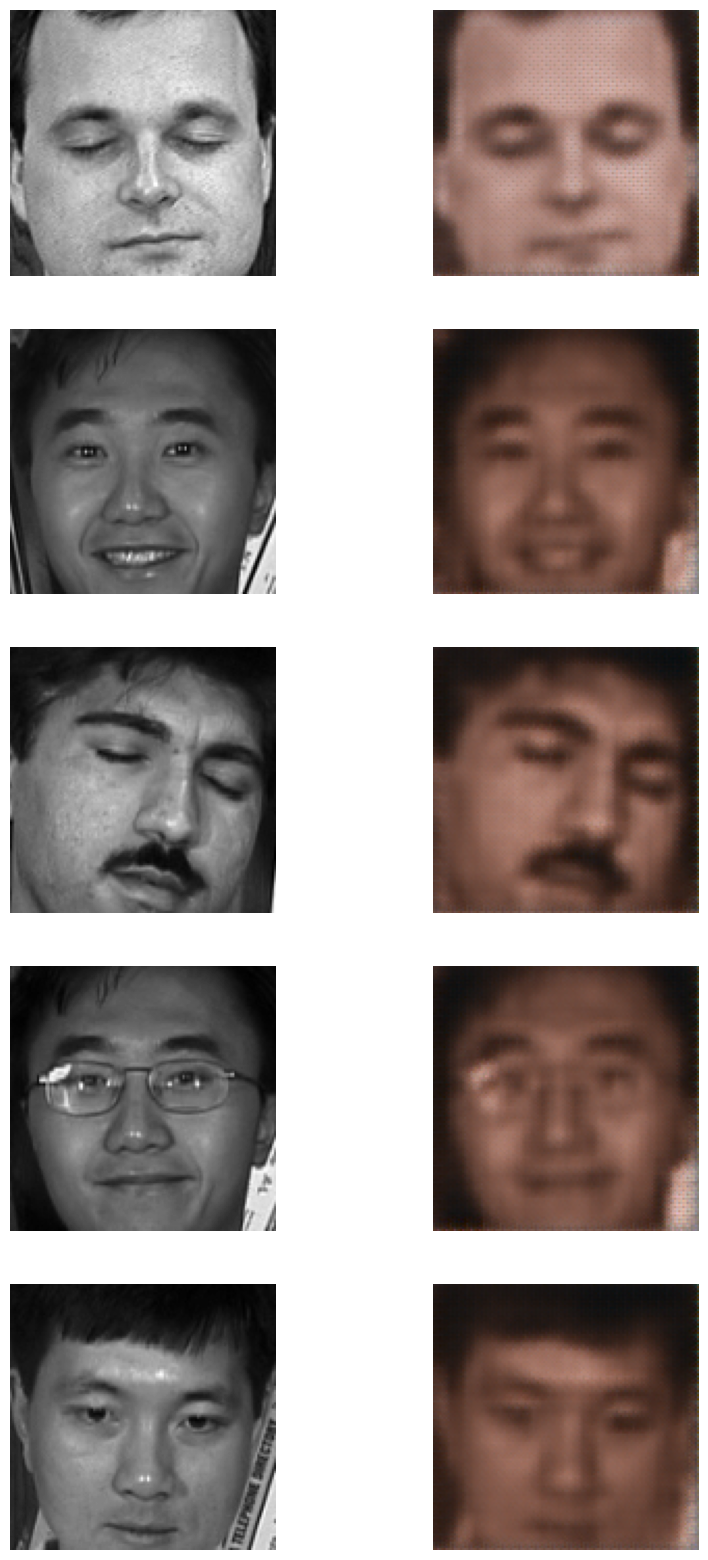

In [20]:
# Set the model to evaluation mode
model.eval()

# Randomly select some test images
test_images = random.sample(image_files, 5)

# Set up a figure with 5 rows (one for each image) and 2 columns (for grayscale and color images)
fig, axs = plt.subplots(5, 2, figsize=(10, 20))

# Iterate over the selected test images
for i, image_name in enumerate(test_images):
    # Load the grayscale image
    image_path = os.path.join(dataset_folder_path, image_name)
    gray_image = Image.open(image_path).convert("L")
    
    # Display the grayscale image
    axs[i, 0].imshow(gray_image, cmap="gray")
    axs[i, 0].axis('off')  # Hide axes

    # Preprocess the grayscale image
    gray_image = transform(gray_image).unsqueeze(0).to(device)

    # Pass the grayscale image through the model to obtain the reconstructed colored image
    with torch.no_grad():
        colored_image = model(gray_image)
        
    # Convert the output tensor to a CPU tensor and then to a NumPy array
    colored_image = colored_image.squeeze(0).cpu()
    numpy_image = np.transpose(colored_image.numpy(),axes = (1,2,0))
    
    # Convert the output tensor to an image in the LAB color space, then convert to RGB
    numpy_image = (numpy_image * 255).astype(np.uint8)
    rgb_image = cv2.cvtColor(numpy_image, cv2.COLOR_LAB2RGB)
    
    # Display the colored image
    axs[i, 1].imshow(rgb_image)
    axs[i, 1].axis('off')  # Hide axes

# Display the figure
plt.show()